<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/Transformers_LayoutLM_Document_Classification_FineTuning_and_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers LayoutLM - Document Classification - FineTuning and Inference

Adapted from [link](https://colab.research.google.com/drive/1DUpTi2aL64AuIJ_9g6dGgKfltEEFqQbt?usp=sharing)

In this notebook, we are going to fine-tune `LayoutLMForSequenceClassification` on the [RVL-CDIP dataset](https://www.cs.cmu.edu/~aharley/rvl-cdip/), which is a document image classification task. Each scanned document in the dataset belongs to one of 16 classes, such as "resume" or "invoice" (so it's a multiclass classification problem). The entire dataset consists of no less than 400,000 (!) scanned documents. 

For demonstration purposes, we are going to fine-tune the model on a really small subset (one example per class), and verify whether the model is able to overfit them. Note that LayoutLM achieves state-of-the-art results on RVL-CDIP, with a classification accuracy of 94.42% on the test set.

* Original LayoutLM paper: https://arxiv.org/abs/1912.13318
* LayoutLM docs in the Transformers library: https://huggingface.co/transformers/model_doc/layoutlm.html

## Install

In [ ]:
!pip install transformers datasets

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

## Import

In [1]:
import pytesseract
import shutil
import os
import random
import os, json, cv2, random
import numpy as np
from google.colab.patches import cv2_imshow

from PIL import ImageDraw, ImageFont
try:
 from PIL import Image
except ImportError:
 import Image

## Getting the data

Next, we download a small subset of the RVL-CDIP dataset, containing 15 documents (one example per class).

In [2]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/kuw05qmc4uy474d/RVL_CDIP_one_example_per_class.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Let's look at a random training example 

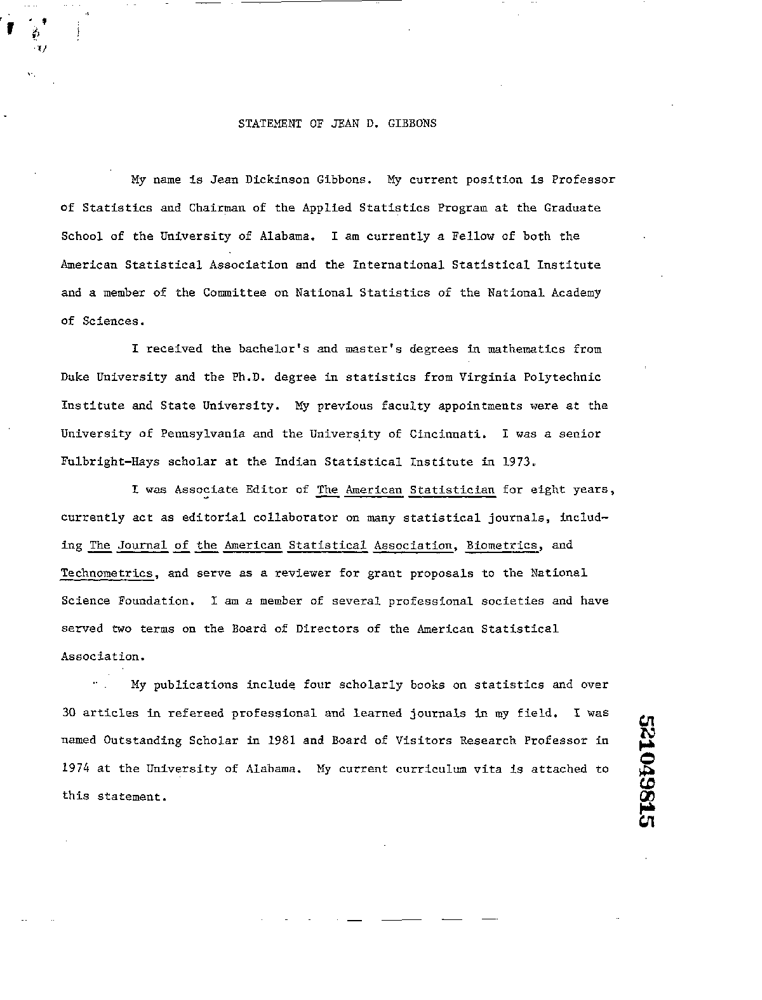

In [3]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/RVL_CDIP_one_example_per_class/resume/0000157402.tif")
image = image.convert("RGB")
image

We can use the Tesseract OCR engine to turn the image into a list of recognized words:

In [4]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

"ot uv STATEMENT OF JEAN D, GIBBONS My name 4s Jean Dickinson Gibbons. My current position is Professor of Statistics and Chairman of the Applied Statistics Program at the Graduate School of the University of Alabana, I am currently a Fellow of both the American Statistical Association and the International Statistical Institute and a menber of the Committee on National Statistics of the National, Acadeny of Scdences. I received the bachelor's and master's degrees in mathematics from Duke University and the Ph.D. degree in statistics from Virginia Polytechnic Institute and State University. My previous faculty appointments were at the University of Pennsylvania and the University of Cincinnati. I was a senior Fulbright-Hays scholar at the Indian Statistical Institute in 1973. Twas Associate Editor of The Anertcan Statistician for eight years, currently act as editortal collaborator on many statistical journals, includ~ Technometrics, and serve as a reviewer for grant proposals to the N

We can also visualize the bounding boxes of the recognized words, as follows:

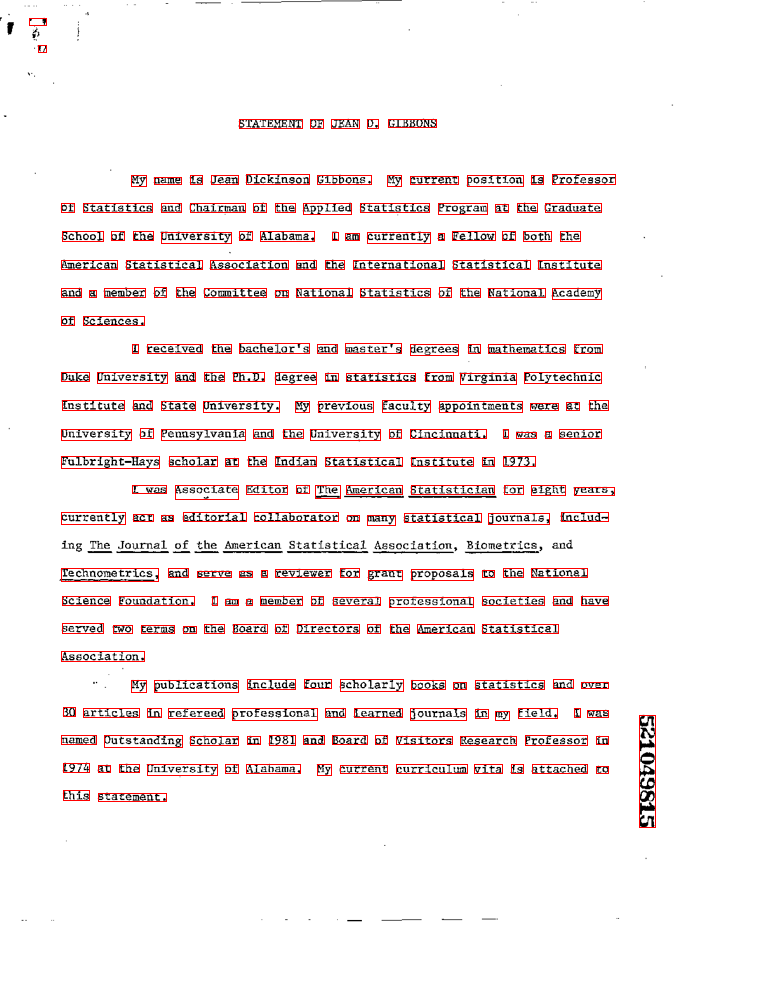

In [5]:
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
    x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
    actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
    actual_boxes.append(actual_box)

draw = ImageDraw.Draw(image, "RGB")
for box in actual_boxes:
  draw.rectangle(box, outline='red')

image

## Preprocessing the data using 🤗 datasets

First, we convert the dataset into a Pandas dataframe, having 2 columns: `image_path` and `label`.

In [35]:
import pandas as pd
import os

# The root folder has a a folder by class 
dataset_path = "/content/RVL_CDIP_one_example_per_class"
list_labels = [label for label in os.listdir(dataset_path)] 

print(f"Number of labels : {len(list_labels)}")
print(list_labels)

Number of labels : 15
['advertisement', 'specification', 'file_folder', 'memo', 'invoice', 'form', 'news_article', 'budget', 'scientific_report', 'letter', 'questionnaire', 'scientific_publication', 'resume', 'email', 'presentation']


In [36]:
# Assign a identifier by label
idx2label = {v: k for v, k in enumerate(list_labels)}
label2idx = {k: v for v, k in enumerate(list_labels)}
label2idx

{'advertisement': 0,
 'budget': 7,
 'email': 13,
 'file_folder': 2,
 'form': 5,
 'invoice': 4,
 'letter': 9,
 'memo': 3,
 'news_article': 6,
 'presentation': 14,
 'questionnaire': 10,
 'resume': 12,
 'scientific_publication': 11,
 'scientific_report': 8,
 'specification': 1}

In [8]:
for label_folder, _, file_names in os.walk(dataset_path):
  if label_folder != dataset_path:
    label = os.path.basename(label_folder)
    print(label)

advertisement
specification
file_folder
memo
invoice
form
news_article
budget
scientific_report
letter
questionnaire
scientific_publication
resume
email
presentation


In [9]:
# Create a dataframe with label and image_path of each image
images = []
labels = []

for label_folder, _, file_names in os.walk(dataset_path):
  if label_folder != dataset_path:

    # Label as name of the last folder of the full path
    label = os.path.basename(label_folder)

    # Foreach image file in the current label folder
    relative_image_names = []
    for _, _, image_names in os.walk(label_folder):

      # Generate the image static paths 
      for image in image_names:
        relative_image_names.append(dataset_path + "/" + label + "/" + image) 

    # Append image filepaths
    images.extend(relative_image_names)
    # Append so label as the same number of the image filepaths
    labels.extend([label] * len (relative_image_names)) 

# Generate dataframe
data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})
data.head()

,image_path,label
0,/content/RVL_CDIP_one_example_per_class/advert...,advertisement
1,/content/RVL_CDIP_one_example_per_class/specif...,specification
2,/content/RVL_CDIP_one_example_per_class/file_f...,file_folder
3,/content/RVL_CDIP_one_example_per_class/memo/0...,memo
4,/content/RVL_CDIP_one_example_per_class/invoic...,invoice


In [10]:
print(f"Number of examples : {len(data)}")
print(f"Number of classes : {len(data['label'].unique())}")

Number of examples : 15
Number of classes : 15


Now, let's apply OCR to get the words and bounding boxes of every image. To do this efficiently, we turn our Pandas dataframe into a HuggingFace `Dataset` object, and use the `.map()` functionality to get the words and normalized bounding boxes of every image. Note that this can take a while to run (Tesseract seems a bit slow).

In [11]:
from datasets import Dataset

def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

def apply_ocr(example):
        # get the image
        image = Image.open(example['image_path'])

        width, height = image.size
        
        # apply ocr to the image 
        ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
        float_cols = ocr_df.select_dtypes('float').columns
        ocr_df = ocr_df.dropna().reset_index(drop=True)
        ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
        ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
        ocr_df = ocr_df.dropna().reset_index(drop=True)

        # get the words and actual (unnormalized) bounding boxes
        #words = [word for word in ocr_df.text if str(word) != 'nan'])
        words = list(ocr_df.text)
        words = [str(w) for w in words]
        coordinates = ocr_df[['left', 'top', 'width', 'height']]
        actual_boxes = []
        for idx, row in coordinates.iterrows():
            x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
            actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
            actual_boxes.append(actual_box)
        
        # normalize the bounding boxes
        boxes = []
        for box in actual_boxes:
            boxes.append(normalize_box(box, width, height))
        
        # add as extra columns 
        assert len(words) == len(boxes)
        example['words'] = words
        example['bbox'] = boxes
        return example

dataset = Dataset.from_pandas(data)
updated_dataset = dataset.map(apply_ocr)

Next, we can turn the word-level 'words' and 'bbox' columns into token-level `input_ids`, `attention_mask`, `bbox` and `token_type_ids` using `LayoutLMTokenizer`.

In [12]:
from transformers import LayoutLMTokenizer
import torch

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

def encode_example(example, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):
  words = example['words']
  normalized_word_boxes = example['bbox']

  assert len(words) == len(normalized_word_boxes)

  token_boxes = []
  for word, box in zip(words, normalized_word_boxes):
      word_tokens = tokenizer.tokenize(word)
      token_boxes.extend([box] * len(word_tokens))
  
  # Truncation of token_boxes
  special_tokens_count = 2 
  if len(token_boxes) > max_seq_length - special_tokens_count:
      token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
  
  # add bounding boxes of cls + sep tokens
  token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
  
  encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
  # Padding of token_boxes up the bounding boxes to the sequence length.
  input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
  padding_length = max_seq_length - len(input_ids)
  token_boxes += [pad_token_box] * padding_length
  encoding['bbox'] = token_boxes
  encoding['label'] = label2idx[example['label']]

  assert len(encoding['input_ids']) == max_seq_length
  assert len(encoding['attention_mask']) == max_seq_length
  assert len(encoding['token_type_ids']) == max_seq_length
  assert len(encoding['bbox']) == max_seq_length

  return encoding

In [13]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D

# we need to define the features ourselves as the bbox of LayoutLM are an extra feature
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(names=['refuted', 'entailed']),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})

encoded_dataset = updated_dataset.map(lambda example: encode_example(example), 
                                      features=features)

Finally, we set the format to PyTorch, as the LayoutLM implementation in the Transformers library is in PyTorch. We also specify which columns we are going to use.

In [14]:
encoded_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

In [15]:
dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1, shuffle=True)
batch = next(iter(dataloader))
batch

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Let's verify whether the input ids are created correctly by decoding them back to text:

In [16]:
tokenizer.decode(batch['input_ids'][0].tolist())

"[CLS] [ ( geitm 7 ye mac moee ~ oct igs7 ‘ only viceroy gives you > | fbilter - power of 20, 000 filters 4 : i the viceroy filter an ordinary filter i i yow can se the dtrence ia the ff ever tiers, cvaser fers in aw i : vier tiptsoduonite! tharsteie ff bl oriony iter tpt the simple erave 4 ss my fiers yon et the ter the aitrenee eater randy fo swthepter smoot rove a i for the smoothest taste of all! “ al j vo yes, twice as many filters as the i | other two largest - selling filter brands! — rey — — 4 | : \\ ow etthe titer power of 1 vieeroy'e 204000 fers ‘ now atthe. i waning h fgh, fineual i bccn that vieroy deep cute forester smote | ‘ smoothest td - ms | job no, v. 8396, 806820099 octeter, 1987 be eee oxtober 1957 166 lt icins ct ) nat prot soy 25. 1957 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [17]:
idx2label[batch['label'][0].item()]

'advertisement'

## Define the model

Here we define the model, namely `LayoutLMForSequenceClassification`. We initialize it with the weights of the pre-trained base model (`LayoutLMModel`). The weights of the classification head are randomly initialized, and will be fine-tuned together with the weights of the base model on our tiny dataset. Once loaded, we move it to the GPU.


In [18]:
from transformers import LayoutLMForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForSequenceClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(label2idx))
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForSequenceClassification were not initialized from the model checkpoint 

LayoutLMForSequenceClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
      

## Train the model

Here we train the model in familiar PyTorch fashion. We use the Adam optimizer with weight decay fix (normally you can also specify which variables should have weight decay and which not + a learning rate scheduler, see [here](https://github.com/microsoft/unilm/blob/5d16c846bec56b6e88ec7de4fc3ceb7c803571a4/layoutlm/examples/classification/run_classification.py#L94) for how the authors of LayoutLM did this), and train for 30 epochs. If the model is able to overfit it, then it means there are no issues and we can train it on the entire dataset.

In [19]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 15
t_total = len(dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  for batch in dataloader:
      input_ids = batch["input_ids"].to(device)
      bbox = batch["bbox"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      token_type_ids = batch["token_type_ids"].to(device)
      labels = batch["label"].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox,
                      attention_mask=attention_mask, 
                      token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == labels).float().sum()

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1
  
  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / len(data)
  print("Training accuracy:", accuracy.item())

Epoch: 0
Loss: 41.31208896636963
Training accuracy: 0.0
Epoch: 1
Loss: 41.772929668426514
Training accuracy: 6.6666669845581055
Epoch: 2
Loss: 38.74052691459656
Training accuracy: 13.333333969116211
Epoch: 3
Loss: 36.496373295784
Training accuracy: 40.000003814697266
Epoch: 4
Loss: 32.1189079284668
Training accuracy: 60.000003814697266
Epoch: 5
Loss: 26.639791250228882
Training accuracy: 100.00000762939453
Epoch: 6
Loss: 23.342451214790344
Training accuracy: 86.66667175292969
Epoch: 7
Loss: 17.981575846672058
Training accuracy: 100.00000762939453
Epoch: 8
Loss: 14.41776967048645
Training accuracy: 100.00000762939453
Epoch: 9
Loss: 11.398004412651062
Training accuracy: 100.00000762939453
Epoch: 10
Loss: 9.78695347905159
Training accuracy: 100.00000762939453
Epoch: 11
Loss: 7.428663849830627
Training accuracy: 100.00000762939453
Epoch: 12
Loss: 5.745119988918304
Training accuracy: 100.00000762939453
Epoch: 13
Loss: 4.991441756486893
Training accuracy: 100.00000762939453
Epoch: 14
Loss: 4

## Inference

In this section we use the finetuned model to predict the label from an image of a document.

We don't reuse the previous functions of ocr and feature convertion to make it easier and have other ways of preprocessing. 

### Test image

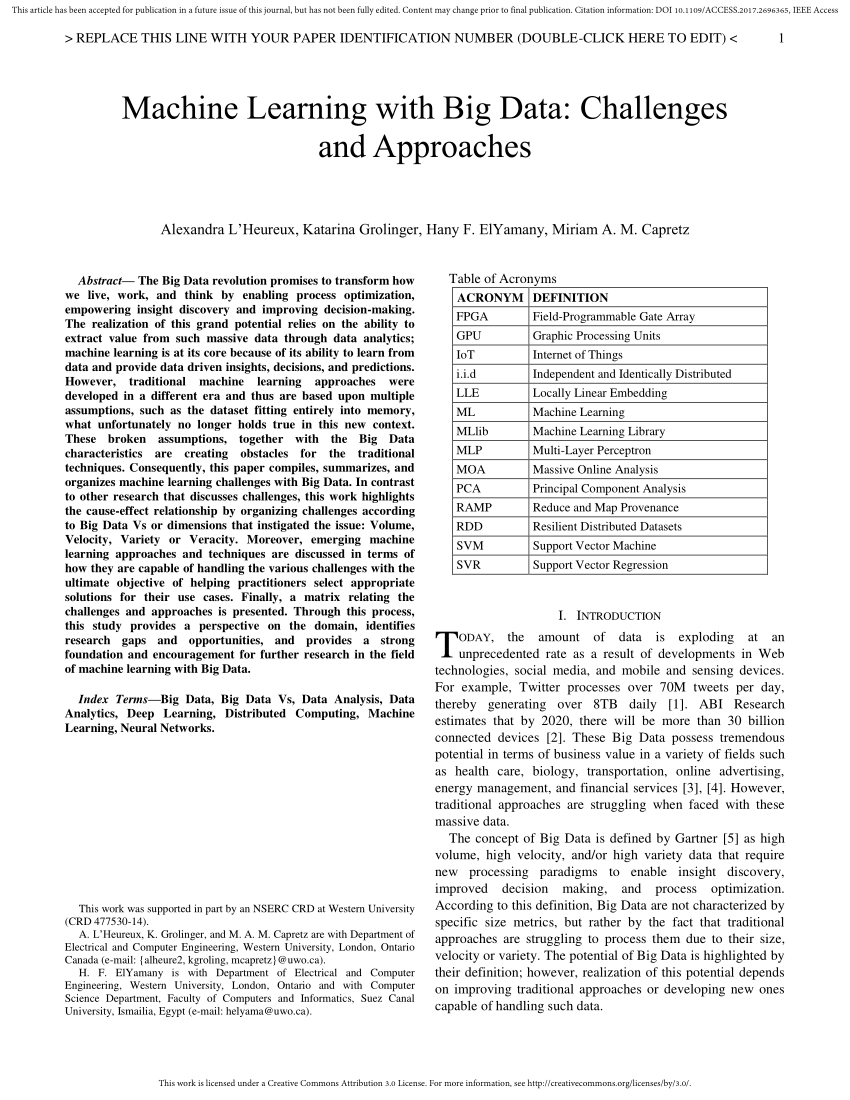

In [21]:
image_path_in_colab="./input.png"


!wget https://i1.rgstatic.net/publication/316448042_Machine_Learning_With_Big_Data_Challenges_and_Approaches/links/5915a79d4585152e199f5b4f/largepreview.png -q -O {image_path_in_colab}

image = Image.open(image_path_in_colab)
image = image.convert("RGB")
image

### Extract text and bounding box

We use [PyTesseract](https://github.com/madmaze/pytesseract)

In [25]:
# Extract data from the image
ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)

# Remove decimals in float columns
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)

# Clean dataframe
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
ocr_df.dropna(subset = ["text"], inplace=True)

# Visualization
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
display(words)
print()
ocr_df.head()

"This article has been accepted for publication in a future issue of this journal, but has not been fully edited. Content may change prior to final publication. Cstation information: DOI 10.1109/ACCESS 2017 2696365, IEEE Access > REPLACE THIS LINE WITH YOUR PAPER IDENTIFICATION NUMBER (DOUBLE-CLICK HERE TO EDIT) < 1 Machine Learning with Big Data: Challenges and Approaches Alexandra L’Heureux, Katarina Grolinger, Hany F. ElYamany, Miriam A. M. Capretz Abstract—The Big Data revolution promises to transform how wwe live, work, and think by enabling process optimization, empowering insight discovery and improving decision ‘The realization of this grand potential rel extract value from such massive data through data analytics; machine learning is at its core because of y to learn from data and provide data driven insights, decisions, and predictions. However, traditional machine learning approaches were developed in a different era and thus are based upon multiple assumptions, such as the 

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,5,1,1,1,1,1,14,6,10,7,79,This
1,5,1,1,1,1,2,25,6,27,7,82,article
2,5,1,1,1,1,3,55,6,12,7,92,has
3,5,1,1,1,1,4,70,8,16,5,95,been
4,5,1,1,1,1,5,89,6,31,9,88,accepted


Define the bounding boxes

In [26]:
width, height = image.size

words = list(ocr_df.text)
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
  x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
  actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 
  actual_boxes.append(actual_box)

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

boxes = []
for box in actual_boxes:
  boxes.append(normalize_box(box, width, height))
boxes[0:10]

[[16, 5, 28, 11],
 [29, 5, 61, 11],
 [64, 5, 78, 11],
 [82, 7, 101, 11],
 [104, 5, 141, 13],
 [144, 6, 156, 11],
 [160, 5, 204, 13],
 [205, 8, 218, 11],
 [222, 8, 225, 11],
 [229, 7, 255, 11]]

Visualize the bounding boxes

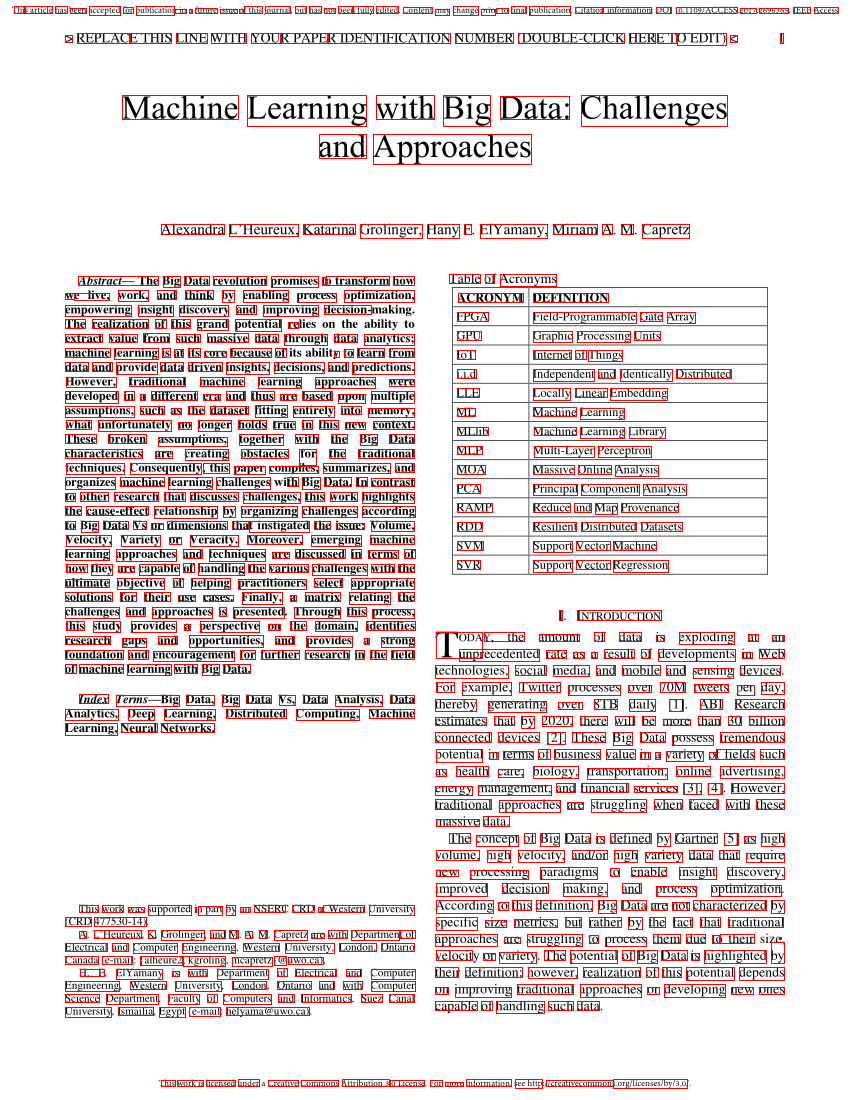

In [27]:
image2 = image.copy()
draw = ImageDraw.Draw(image2, "RGB")
for box in actual_boxes:
  draw.rectangle(box, outline='red')

image2

### Generate input 

In [28]:
def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, 
                                max_seq_length=512, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
      width, height = image.size

      tokens = []
      token_boxes = []
      actual_bboxes = [] # we use an extra b because actual_boxes is already used
      token_actual_boxes = []
      for word, box, actual_bbox in zip(words, boxes, actual_boxes):
          word_tokens = tokenizer.tokenize(word)
          tokens.extend(word_tokens)
          token_boxes.extend([box] * len(word_tokens))
          actual_bboxes.extend([actual_bbox] * len(word_tokens))
          token_actual_boxes.extend([actual_bbox] * len(word_tokens))
      
      # Truncation: account for [CLS] and [SEP] with "- 2". 
      special_tokens_count = 2 
      if len(tokens) > max_seq_length - special_tokens_count:
          tokens = tokens[: (max_seq_length - special_tokens_count)]
          token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
          actual_bboxes = actual_bboxes[: (max_seq_length - special_tokens_count)]
          token_actual_boxes = token_actual_boxes[: (max_seq_length - special_tokens_count)]

      # add [SEP] token, with corresponding token boxes and actual boxes
      tokens += [tokenizer.sep_token]
      token_boxes += [sep_token_box]
      actual_bboxes += [[0, 0, width, height]]
      token_actual_boxes += [[0, 0, width, height]]
      
      segment_ids = [0] * len(tokens)

      # next: [CLS] token
      tokens = [tokenizer.cls_token] + tokens
      token_boxes = [cls_token_box] + token_boxes
      actual_bboxes = [[0, 0, width, height]] + actual_bboxes
      token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
      segment_ids = [1] + segment_ids

      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      input_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = max_seq_length - len(input_ids)
      input_ids += [tokenizer.pad_token_id] * padding_length
      input_mask += [0] * padding_length
      segment_ids += [tokenizer.pad_token_id] * padding_length
      token_boxes += [pad_token_box] * padding_length
      token_actual_boxes += [pad_token_box] * padding_length

      assert len(input_ids) == max_seq_length
      assert len(input_mask) == max_seq_length
      assert len(segment_ids) == max_seq_length
      #assert len(label_ids) == max_seq_length
      assert len(token_boxes) == max_seq_length
      assert len(token_actual_boxes) == max_seq_length
      
      return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes

In [29]:
input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image, words=words, boxes=boxes, actual_boxes=actual_boxes, tokenizer=tokenizer)

Convert the arrays to tensor

In [30]:
input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)

### Run prediction

In [31]:
outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
outputs.keys()

odict_keys(['logits'])

In [37]:
print(f"Logits : {outputs['logits']}")
print(f"Predict class : {outputs.logits.argmax(-1).squeeze().tolist()}")
print(f"Predict lable : {list_labels[outputs.logits.argmax(-1).squeeze().tolist()]}")

Logits : tensor([[-0.3934, -0.7393, -0.8344, -0.2090,  0.2289,  0.1136,  0.2197, -0.4481,
         -0.2407, -0.7898, -0.0197,  1.9121,  0.2374, -0.1293, -0.7645]],
       device='cuda:0', grad_fn=<AddmmBackward>)
Predict class : 11
Predict lable : scientific_publication
